# Griffin-Lim algorithm comparison between LibROSA and TF

In [37]:
import glob
import tempfile
import time

import librosa.display
import yaml

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# from ipywidgets import GridBox, Label, Layout, Audio
from IPython.display import display, Audio
# display(Audio(wav.view(-1).cpu().numpy(), rate=fs))

from tensorflow_tts.utils import TFGriffinLim, griffin_lim_lb

# %config InlineBackend.figure_format = 'svg'

Get mel spectrogram example and corresponding ground truth audio.

In [38]:
mel_spec = np.load("../dump/train/raw-feats/1-raw-feats.npy")
gt_wav = np.load("../dump/train/wavs/1-wave.npy")

stats_path = "../dump/stats.npy"
dataset_config_path = "../preprocess/baker_preprocess.yaml"
config = yaml.load(open(dataset_config_path), Loader=yaml.Loader)

griffin_lim_tf = TFGriffinLim(stats_path, config)

In [39]:
print("mel_spec shape: ", mel_spec.shape)
print("gt_wav shape: ", gt_wav.shape)
print("config\n", config)

mel_spec shape:  (197, 80)
gt_wav shape:  (59100,)
config
 {'sampling_rate': 24000, 'fft_size': 2048, 'hop_size': 300, 'win_length': 1200, 'window': 'hann', 'num_mels': 80, 'fmin': 80, 'fmax': 7600, 'global_gain_scale': 1.0, 'trim_silence': True, 'trim_threshold_in_db': 60, 'trim_frame_size': 2048, 'trim_hop_size': 512, 'format': 'npy'}


TF version has GPU compatibility and supports batch dimension.

In [40]:
inv_wav_tf = griffin_lim_tf(mel_spec[tf.newaxis, :], n_iter=32)  # [1, mel_len] -> [1, audio_len]
inv_wav_lb = griffin_lim_lb(mel_spec, stats_path, config)  # [mel_len] -> [audio_len]

In [34]:
np.min(inv_wav_lb)

-0.008123399

Time comparison between both implementations.

In [5]:
%timeit griffin_lim_tf(mel_spec[tf.newaxis, :])

56.3 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%timeit griffin_lim_lb(mel_spec, stats_path, config)

403 ms ± 15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
tf_wav = tf.audio.encode_wav(inv_wav_tf[0, :, tf.newaxis], config["sampling_rate"])
lb_wav = tf.audio.encode_wav(inv_wav_lb[:, tf.newaxis], config["sampling_rate"])
gt_wav_ = tf.audio.encode_wav(gt_wav[:, tf.newaxis], config["sampling_rate"])

In [8]:
items = [
    Audio(value=x.numpy(), autoplay=False, loop=False)
    for x in [gt_wav_, lb_wav, tf_wav]
]
labels = [Label("Ground Truth"), Label("Librosa"), Label("TensorFlow")]
GridBox(
    children=[*labels, *items],
    layout=Layout(grid_template_columns="25% 25% 25%", grid_template_rows="30px 30px"),
)

GridBox(children=(Label(value='Ground Truth'), Label(value='Librosa'), Label(value='TensorFlow'), Audio(value=…

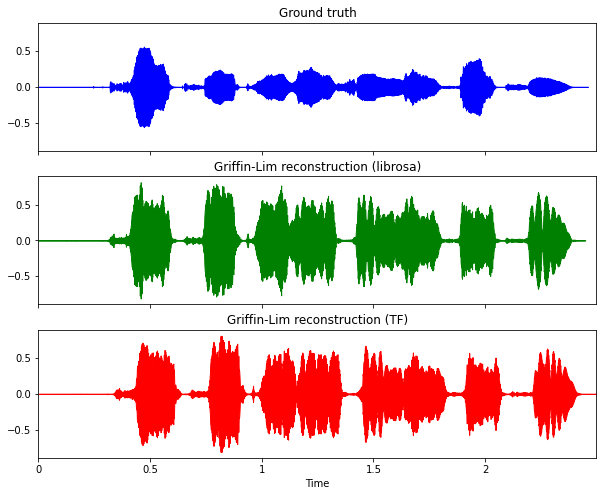

In [36]:
_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharey=True, sharex=True)
librosa.display.waveplot(gt_wav, sr=config["sampling_rate"], color="b", ax=ax1)
ax1.set_title("Ground truth")
ax1.set_xlabel("")
librosa.display.waveplot(inv_wav_lb*100, sr=config["sampling_rate"], color="g", ax=ax2)
ax2.set_title("Griffin-Lim reconstruction (librosa)")
ax2.set_xlabel("")
librosa.display.waveplot(
    inv_wav_tf[0].numpy()*100, sr=config["sampling_rate"], color="r", ax=ax3
)
ax3.set_title("Griffin-Lim reconstruction (TF)");

In [25]:
def gen():
    file_list = glob.glob("../dump/train/norm-feats/*-norm-feats.npy")
    for file in file_list:
        yield np.load(file)


mel_ds = tf.data.Dataset.from_generator(
    gen, (tf.float32), tf.TensorShape([None, config["num_mels"]])
).padded_batch(10)

for mel_batch in mel_ds.take(5):
    start_batch = time.perf_counter()
    inv_wav_tf_batch = griffin_lim_tf(mel_batch)
    print(
        f"Iteration time: {time.perf_counter() - start_batch:.4f}s, output shape: {inv_wav_tf_batch.shape}"
    )

Saving outputs with both implementations.

In [31]:
# Single file
griffin_lim_lb(mel_spec, stats_path, config, output_dir="../tmp", wav_name="lb")
griffin_lim_tf.save_wav(inv_wav_tf, output_dir="../tmp", wav_name="tf")

# # Batch files
# griffin_lim_tf.save_wav(inv_wav_tf_batch, tempfile.gettempdir(), [x for x in range(10)])

# %ls {tempfile.gettempdir()} | grep '.wav'

In [27]:
tempfile.gettempdir()

'/tmp'